In [2]:
from sympt import *
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
cmap = plt.get_cmap('inferno')
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', weight = 'normal')
plt.rc('font', size = 18)
color_list = [cmap(i) for i in np.linspace(0, 1, 16)]
fntsize = 20

# SymPT Mask

In [4]:
def letter(num):
    # Define the patterns for each letter
    patterns = {
        0: np.array([
            [1, 1, 1],
            [1, 0, 0],
            [1, 1, 1],
            [0, 0, 1],
            [1, 1, 1]
        ]),  # Capital "S"
        1: np.array([
            [0, 0, 0, 0],
            [1, 0, 0, 1],
            [0, 1, 1, 1],
            [0, 0, 0, 1],
            [1, 1, 1, 1]
        ]),  # Lowercase "y"
       2: np.array([
            [0, 0, 0, 0, 0],
            [1, 0, 0, 0, 1],
            [1, 1, 0, 1, 1],
            [1, 0, 1, 0, 1],
            [1, 0, 0, 0, 1]
        ]), # Lowercase "m"
        3: np.array([
            [1, 1, 1],
            [1, 0, 1],
            [1, 1, 1],
            [1, 0, 0],
            [1, 0, 0]
        ]),  # Capital "P"
        4: np.array([
            [1, 1, 1],
            [0, 1, 0],
            [0, 1, 0],
            [0, 1, 0],
            [0, 1, 0]
        ]),  # Capital "T"
        }

    # Return the correct pattern or raise an error if the input is invalid
    if num in patterns:
        return patterns[num]
    else:
        raise ValueError("Input must be a number from 0 to 3.")
space = np.zeros((5,1))
zero_b = np.zeros((5,5)) 
last_pad = np.zeros((12,37))

(37, 37)

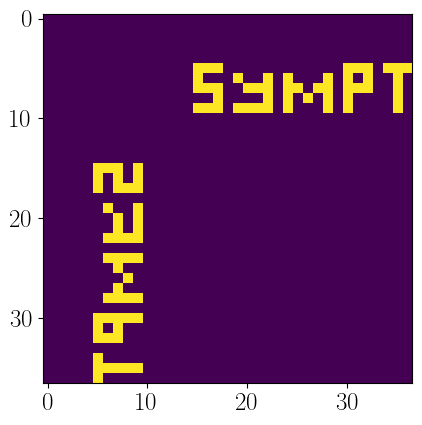

In [5]:
SymPT = np.block(
    [
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [zero_b, zero_b, zero_b, letter(0),space,letter(1),space,letter(2),space,letter(3),space,letter(4)], 
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [zero_b, zero_b, zero_b, zero_b, zero_b, zero_b, space, space, space, space, space, space, space],
        [last_pad]
    ]
)
SymPT = SymPT + SymPT.T
mask = Block(SymPT)
plt.imshow(SymPT)
SymPT.shape

# Hamiltonian

In [6]:
I = SymPT.shape[0]
J = SymPT.shape[1]
omegas = [RDSymbol(f"\\omega_{i}", order = 0, real = True) for i in range(I)]
lambdas = []

H = sp.zeros(I, J)
for i in range(I):
    H[i, i] = omegas[i]
    for j in range(i+1, J):  # Loop only over upper triangular part (including diagonal)
        lambdas.append(RDSymbol(f"\\lambda_{i}_{j}", order = 1, real = True))
        H[i, j] = lambdas[-1]
        H[j, i] = lambdas[-1]  # Ensure symmetry

In [7]:
def substitution_rules(I, J):
    """Returns 2 dictionaries containing substitution rules for H"""
    omega_values = np.sort([np.random.uniform(-10, 10) for _ in range(I)])  
    substitution_dict = {omegas[i]: omega_values[i] for i in range(I)}
    substitution_omegas = {omegas[i]: omega_values[i] for i in range(I)}

    lambda_index = 0
    for i in range(I):
        for j in range(i+1, J):  # Iterate only over the upper triangular part
            bound = 0.1**(lambdas[lambda_index].order) * abs(omega_values[i] - omega_values[j])            
            lambda_value = bound             
            substitution_dict[lambdas[lambda_index]] = lambda_value 
            lambda_index += 1
            
    return substitution_dict
values = substitution_rules(I,J)

In [8]:
Eff_Frame = EffectiveFrame(H, symbol_values = values)

Creating the EffectiveFrame object with matrix form.
The EffectiveFrame object has been initialized successfully.


In [9]:
# Calculate the effective model using mask up to the second order
Eff_Frame.solve(max_order = 3, method = "ACE", mask=mask)
# Obtaining the result in the matrix form
result = Eff_Frame.get_H(return_form = "matrix")

Substituting the symbol values in the Hamiltonian and perturbative interactions.
Computing the effective Hamiltonian: 100%|██████████| 3/3 [00:21<00:00,  7.29s/it]
The Hamiltonian has been solved successfully. Please use the get_H method to get the result in the desired form.
Converting to matrix form: 100%|██████████| 4/4 [00:00<00:00, 83.49it/s]


# Plotting

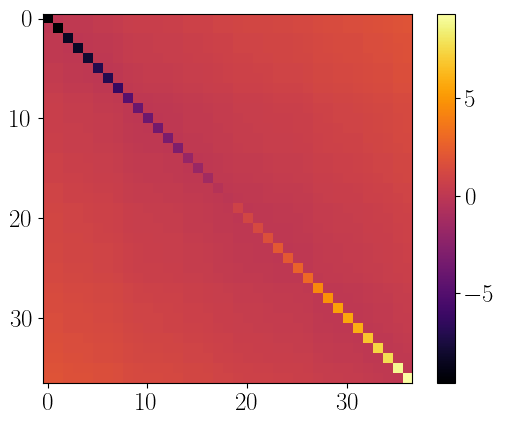

In [10]:
np_H = np.array(H.xreplace(values), dtype = float)

fig, ax = plt.subplots(dpi = 100)
mapp = ax.imshow(np_H, cmap = "inferno")
fig.colorbar(mapp, ax = ax)
#plt.savefig('ACE_non_masked_hamiltonian.pdf', bbox_inches = 'tight')

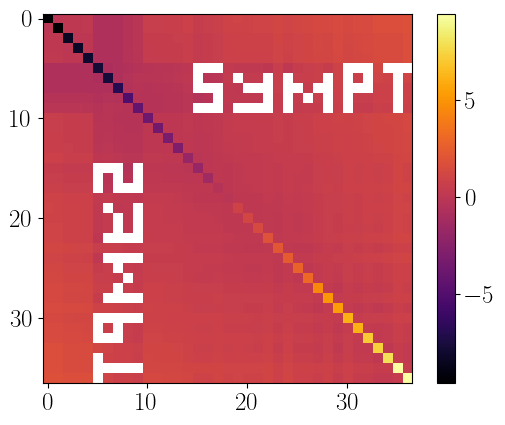

In [11]:
np_result = np.array(result).astype(float)
np_result[np.abs(np_result) == 0] = None

fig, ax = plt.subplots(dpi = 100)
mapp = ax.imshow(np_result, cmap = "inferno")
fig.colorbar(mapp)
#plt.savefig('ACE_masked_hamiltonian.pdf',  bbox_inches='tight')